# JaxRK hyperparameter optimization using FLAX and Optax


In [1]:
%autoreload 2
import jax.numpy as np, pylab as pl
import jax
from jaxrk.rkhs import Cdo, Cmo, LinOp, FiniteVec, FiniteOp, inner, CovOp, Cov_solve, Cov_inv
from jaxrk.kern import (GenGaussKernel, SplitDimsKernel, PeriodicKernel)
from jaxrk.utilities.distances import rkhs_cdist
from jaxrk.core.constraints import CholeskyBijection
from jaxrk.reduce import *
from jax import random
import optax as ot
import flax.linen as nn
import flax, flax.training.train_state



key1, key2 = random.split(random.PRNGKey(0))

### Conditonal density estimates using the CDO

In what follows, we will create a simple data set and do conditional density estimates for it using the  [conditional density operator (CDO)](https://arxiv.org/abs/1905.11255).

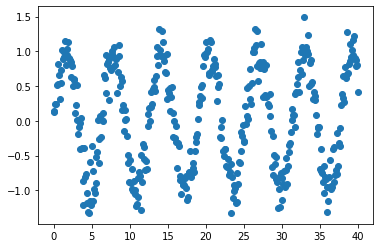

In [2]:
from numpy.random import randn
from jax import random

x = np.linspace(0, 40, 400).reshape((-1, 1))
rng_key = random.PRNGKey(0)
y = np.sin(x) + random.normal(rng_key, (len(x), 1))* 0.2

pl.scatter(x.T, y.T)

In [3]:
def plot_pred(mean_var, x, y, points_per_split = 1):
    if points_per_split == 1:
        rep_x = x
    else:
        rep_x = np.repeat(x, points_per_split, axis=0)
        
    pl.plot(x[200:].flatten(), mean_var.T[0].flatten(), color="red")
    pl.scatter(rep_x.T[:200], y.T[:200 * points_per_split].flatten(), color="green")
    pl.scatter(rep_x.T[200:], y.T[200 * points_per_split:].flatten(), color="green")
    sd = np.sqrt(mean_var.T[1].flatten())
    pl.fill_between(x[200:].flatten(), mean_var.T[0].flatten() + sd, mean_var.T[0].flatten() - sd, color="red", alpha=0.2)

Now, lets build a simple model regressing from index to output distribution using the prior information that the output depends periodically on the input. This is encoded in the fact that the input features use a periodic kernel.

In [4]:
class Cmo_hyperparam(nn.Module):
    inp_batch:np.ndarray
    out_batch:np.ndarray

    def setup(self):
        ik_par = self.param("ik_par", lambda rng, shape: random.normal(rng, shape)/10 + np.array(PeriodicKernel.init_from_constrained(2*np.pi+2, 1.)), (2,))
        vec_i = FiniteVec(PeriodicKernel.make_unconstr(ik_par[0], ik_par[1]),
                          self.inp_batch)

        ok_par = self.param("ok_par", lambda rng, shape: random.normal(rng, shape)/10 + np.array(GenGaussKernel.init_from_constrained(2, 1.99)), (2,))
        vec_o = FiniteVec(GenGaussKernel.make_unconstr(ok_par[:-1], ok_par[-1]),
                          self.out_batch)

        
        self.O = Cmo(vec_i, vec_o)
    
    def get_operator(self):
        return self.O

    def loss_rkhsdist(self, inp:np.ndarray, out:np.ndarray):
        cmes = self.O@inp
        out_vec = FiniteVec(self.O.outp_feat.k, out)
        return np.trace(rkhs_cdist(out_vec, cmes, 2.))+np.trace(cmes.inner())
    
    def loss_denseval(self, inp:np.ndarray, out:np.ndarray):
        # Evaluates estimated output densities in output points.
        # As estimated densities can be negative, we can't multiply
        # all the individual estimates. As a heuristic we sum them.
        cmes = self.O@inp
        out_vec = FiniteVec(self.O.outp_feat.k, out)
        rval = -np.trace(cmes.inner(out_vec))
        return rval
        

model = Cmo_hyperparam(inp_batch = x[:199], out_batch=y[:199])
variables = model.init(random.PRNGKey(0), x[:199], y[:199], method=model.loss_denseval)
jax.tree_map(lambda x: x.shape, variables)



FrozenDict({
    params: {
        ik_par: (2,),
        ok_par: (2,),
    },
})

In [5]:
state = flax.training.train_state.TrainState.create(
    apply_fn=lambda vars, i,o: model.apply(vars, i, o, method=model.loss_denseval),
    params=variables["params"],
    tx=ot.fromage(5e-3),
)


def train_step(state, inputs, out):

    def loss_fn(params):
        return state.apply_fn({'params': params}, inputs, out, )

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    new_state = state.apply_gradients(grads=grads)

    return new_state, loss

Now lets plot the prediction with parameters before optimization.

<Figure size 432x288 with 0 Axes>

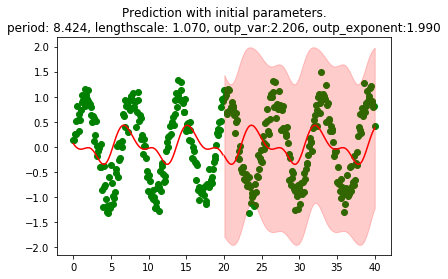

<Figure size 432x288 with 0 Axes>

In [6]:
op = model.apply({'params': variables["params"]}, method=model.get_operator)
mv = np.array((op@ FiniteVec(op.inp_feat.k, x)).get_mean_var()).T
plot_pred(mv[199:399,:], x, y)
pl.plot(x[:199], mv[:199, 0], "r")
pl.title(f"Prediction with initial parameters.\nperiod: {op.inp_feat.k.dist.gs.inv().squeeze():.3f}, lengthscale: {op.inp_feat.k.ls:.3f}, outp_var:{op.outp_feat.k.var().squeeze():.3f}, outp_exponent:{op.outp_feat.k.dist.power:.3f}")
pl.figure()

In [7]:
for i in range(101):
    state, loss = train_step(state, x[:199], y[:199])
    if i % 10 == 0:
        print(f'Loss step {state.step}: ', loss)

Loss step 1:  -43.729816
Loss step 11:  -53.86219
Loss step 21:  -67.5997
Loss step 31:  -86.27591
Loss step 41:  -111.58232
Loss step 51:  -144.99109
Loss step 61:  -174.25269
Loss step 71:  -191.89996
Loss step 81:  -207.86487
Loss step 91:  -222.31935
Loss step 101:  -235.27487


After optimization the prediction looks much better. Also, the period of 2π was correctly recovered.

<Figure size 432x288 with 0 Axes>

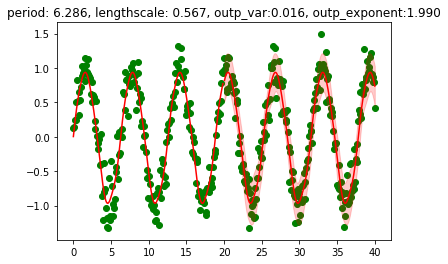

<Figure size 432x288 with 0 Axes>

In [8]:
op = model.apply({'params': state.params}, method=model.get_operator)
#op.inp_feat.k.ls = 1
mv = np.array((op@ FiniteVec(op.inp_feat.k, x)).get_mean_var()).T
plot_pred(mv[199:399,:], x, y)
pl.plot(x[:199], mv[:199, 0], "r")
pl.title(f"period: {op.inp_feat.k.dist.gs.inv().squeeze():.3f}, lengthscale: {op.inp_feat.k.ls:.3f}, outp_var:{op.outp_feat.k.var().squeeze():.3f}, outp_exponent:{op.outp_feat.k.dist.power:.3f}")
pl.figure()